In [47]:
import numpy as np
import pandas as pd
import os
import copy
import seaborn as sbn
import matplotlib.pylab as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

## Loading the datafiles for training and testing models

In [48]:
# Getting path for the 'parent folder'
path_cwd = os.getcwd()
path_parent = os.path.abspath(os.path.join(path_cwd, os.pardir))

# Getting path for the data files
datafiles_folder_name = 'Data_files'
trainfile = 'data_base_demand_train_1.csv'
testfile = 'data_base_demand_test.csv'
path_trainfile = os.path.join(path_parent,datafiles_folder_name,trainfile)
path_testfile = os.path.join(path_parent,datafiles_folder_name,testfile)

In [49]:
#Loading datafiles
operating_scenarios_df_train = pd.read_csv(path_trainfile)
operating_scenarios_df_test = pd.read_csv(path_testfile)

In [50]:
# check shapes
print(operating_scenarios_df_train.shape,operating_scenarios_df_test.shape)

(48, 98) (52, 98)


In [51]:
# Initializing a few parameters
num_demand = 32
num_head = 32
num_flow = 34

In [52]:
# Seperating out the column names in the datafiles among demand, head and flow value column headers
column_demand = operating_scenarios_df_train.columns[:num_demand]
column_head = operating_scenarios_df_train.columns[num_demand:num_demand+num_head]
column_flow = operating_scenarios_df_train.columns[num_demand+num_head:]

In [67]:
# Create a list of headers that contains  Reservoir Head and the nodal demands
column_input = column_demand[:-1].insert(0,column_head[-1])

In [78]:
# Check
column_input

Index(['Res_Head', 'Demand2', 'Demand3', 'Demand4', 'Demand5', 'Demand6',
       'Demand7', 'Demand8', 'Demand9', 'Demand10', 'Demand11', 'Demand12',
       'Demand13', 'Demand14', 'Demand15', 'Demand16', 'Demand17', 'Demand18',
       'Demand19', 'Demand20', 'Demand21', 'Demand22', 'Demand23', 'Demand24',
       'Demand25', 'Demand26', 'Demand27', 'Demand28', 'Demand29', 'Demand30',
       'Demand31', 'Demand32'],
      dtype='object')

## The model is a linear regression model, detailed below:
* Predicts flowrate or nodal head in a specified link or node, given the demand and reservoir head
* Input to the model is hence the demand and reservoir head data, output to learnt or predicted is a single quantity, whcih could be flow in a link or head at a node

In [68]:
# Function to extract data for model training and testing
# Pred type could be 'head' or 'flow'
# Pred num is the number of the node for 'head' type and number of the link for 'flow' type
# Input is always the demand and reservoir head data

def data_for_model(operating_scenarios_df,pred_type,pred_num):
    
    data_in = np.array(operating_scenarios_df[column_input])
    
    if pred_type == 'head':
        data_out = np.array(operating_scenarios_df['Node_head'+str(pred_num)]).reshape(-1,1)
    else:
        data_out = np.array(operating_scenarios_df['Link_flow'+str(pred_num)]).reshape(-1,1)        
    
    
    return data_in, data_out

## Function that works as a linear regression model

In [69]:
# polynomial fit
def polymodel(n,X_train,y_train):
    
    poly = PolynomialFeatures(degree=n)
    X_train_poly = poly.fit_transform(X_train)    
    lin_model = LinearRegression()
    lin_model.fit(X_train_poly,y_train)    
    
    return lin_model

## Below code uses the 'polymodel' function iteratively to train a regression model and make predictions in each iteration. Iterations are made over all the links. Flowrate in the link is learnt and predicted

In [70]:
flow_error_mean=[]
flow_error_std=[]
flow_error_r2=[]
ytest_flow={}
ypred_flow={}
    
    
for i in range(1,35):
    X_train,y_train = data_for_model(operating_scenarios_df_train,'flow',i)
    X_test,y_test = data_for_model(operating_scenarios_df_test,'flow',i)    
    
    lin_model = polymodel(2,X_train,y_train)
    poly = PolynomialFeatures(degree=2)
    X_test_poly = poly.fit_transform(X_test)
    ypred_flow[i] = lin_model.predict(X_test_poly)
    ytest_flow[i] = y_test
    error_flow = ytest[i] - ypred[i]
    flow_error_mean.append(np.mean(error_flow))
    flow_error_std.append(np.std(error_flow))
    flow_error_r2.append(r2_score(ytest_flow[i],ypred_flow[i]))

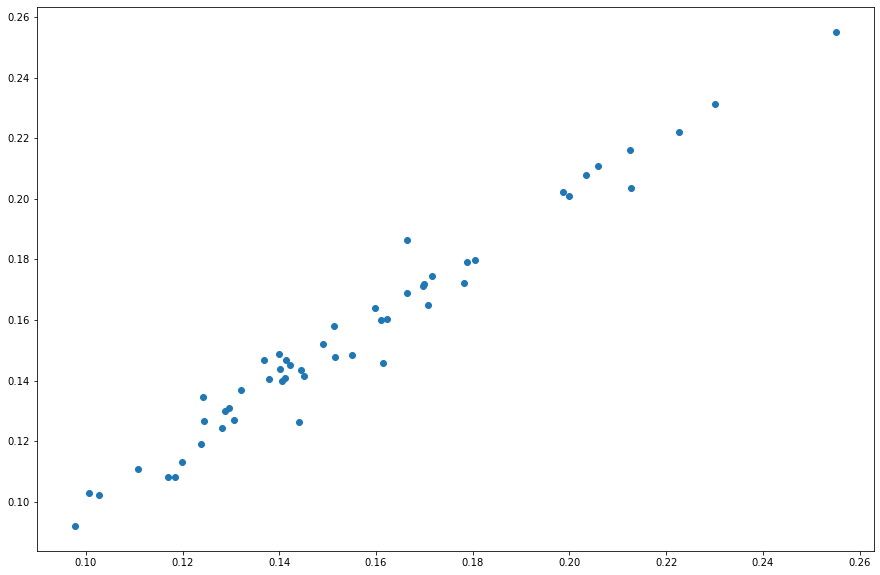

In [71]:
i=30
x=ytest_flow[i]
y=ypred_flow[i]
plt.figure(figsize=(15,10))
plt.scatter(x,y)

In [72]:
PolyReg_flows = pd.DataFrame(columns=['mean','Std','R2'])
PolyReg_flows['mean']=flow_error_mean
PolyReg_flows['Std']=flow_error_std
PolyReg_flows['R2']=flow_error_r2

In [73]:
PolyReg_flows

,mean,Std,R2
0,-0.000907,0.002638,0.989931
1,-0.002432,0.005664,0.989931
2,-0.003982,0.007727,0.990565
3,-0.003867,0.007848,0.991925
4,-0.004516,0.008308,0.989787
5,-0.003851,0.007734,0.991269
6,-0.003454,0.009312,0.987936
7,-0.002927,0.007401,0.982622
8,-0.003817,0.009096,0.974763
9,-0.002493,0.006776,0.973278


## Below code uses the 'polymodel' function iteratively to train a regression model and make predictions in each iteration. Iterations are made over all the nodes and pressure head is learnt and predicted

In [74]:
head_error_mean=[]
head_error_std=[]
head_error_r2=[]
Hytest={}
Hypred={}
    
    
for i in range(2,33):
    X_train_h,y_train_h = data_for_model(operating_scenarios_df_train,'head',i)
    X_test_h,y_test_h = data_for_model(operating_scenarios_df_test,'head',i)
    
    lin_model_h = polymodel(2,X_train_h,y_train_h)
    poly_h = PolynomialFeatures(degree=2)
    X_test_poly_h = poly_h.fit_transform(X_test_h)
    Hypred[i] = lin_model_h.predict(X_test_poly_h)
    Hytest[i] = y_test_h
    error_head = Hytest[i] - Hypred[i]
    head_error_mean.append(np.mean(error_head))
    head_error_std.append(np.std(error_head))
    head_error_r2.append(r2_score(Hytest[i],Hypred[i]))

In [75]:
a,b=data_for_model(operating_scenarios_df_train,'head',2)
print(a.shape,b.shape)

(48, 32) (48, 1)


In [76]:
PolyReg_heads = pd.DataFrame(columns=['mean','Std','R2'])
PolyReg_heads['mean']=head_error_mean
PolyReg_heads['Std']=head_error_std
PolyReg_heads['R2']=head_error_r2

In [77]:
PolyReg_heads

,mean,Std,R2
0,-0.014158,0.071098,0.999999
1,-0.187003,1.010202,0.999717
2,-0.178750,1.048261,0.999695
3,-0.178429,1.136626,0.999642
4,-0.170765,1.236809,0.999577
5,-0.169414,1.274318,0.999551
6,-0.168221,1.341413,0.999504
7,-0.174078,1.396710,0.999462
8,-0.175404,1.436504,0.999431
9,-0.194980,1.477236,0.999397
